In [32]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
data = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'

df = pd.read_csv(data, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


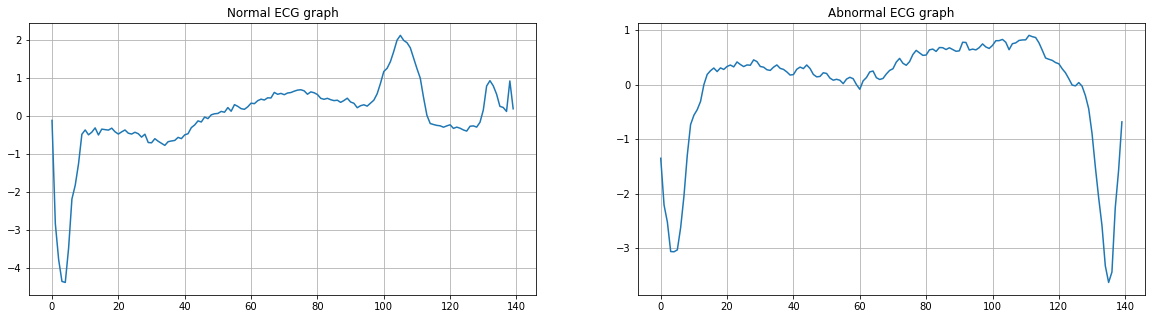

In [3]:
plt.figure(figsize=(20,5))
plt.subplot(121)
ax1 = df.iloc[0,:-1].plot(grid=True)
ax1.set_title('Normal ECG graph')

plt.subplot(122)
ax2 = df.iloc[-1,:-1].plot(grid=True)
ax2.set_title('Abnormal ECG graph')
plt.show()

## Train test split

In [4]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## Nomarlize data

In [5]:
maxi = X_train.max(axis=0)
mini = X_train.min(axis=0)

train_X = (X_train - mini) / (maxi - mini)
valid_X = (X_valid - mini) / (maxi - mini)

In [6]:
# casting to tensor
train_X = tf.cast(train_X, tf.float32)
valid_X = tf.cast(valid_X, tf.float32)

- we only concern about <b>Normal ECG</b> data

In [7]:
normal_X_train = train_X[y_train == 1]
normal_X_valid = valid_X[y_valid == 1]

anamalous_X_train = train_X[y_train == 0]
anamalous_X_valid = valid_X[y_valid == 0]

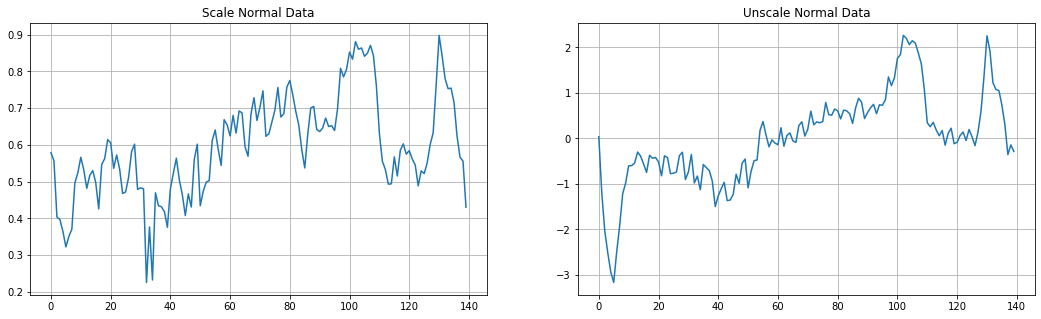

In [31]:
plt.figure(figsize=(18, 5))

plt.subplot(121)
plt.grid()
plt.plot(normal_X_train[0])
plt.title('Scale Normal Data')

plt.subplot(122)
plt.grid()
plt.plot(X_train[y_train == 1][0])
plt.title('Unscale Normal Data')

plt.show()